# Preprocessing

In [3]:
import geopandas as gpd
import shapely.geometry
import shapely.wkt
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import subprocess

pd.set_option('display.max_rows', 4)

In [64]:
DATA_FOLDER = 'Data/'
LAND_COVER = DATA_FOLDER+'LC_1990/DATA/LC_1990.tif'
SLOPE = DATA_FOLDER+'slope.tif'
DEM = DATA_FOLDER+'dem.tif'
FIRE_YEAR = DATA_FOLDER+'raster_fireyear.tif'
PROTECTED = DATA_FOLDER+'raster_natural_protected.tif'
DEPARTEMENTS = DATA_FOLDER+'Contours/departements-20170102.shp'

## Actual files

LC_CROPPED_90 = DATA_FOLDER+'LC/land_cover_1990.tif'
LC_CROPPED_00 = DATA_FOLDER+'LC/land_cover_2000.tif'
LC_CROPPED_06 = DATA_FOLDER+'LC/land_cover_2006.tif'
LC_CROPPED_12 = DATA_FOLDER+'LC/land_cover_2012.tif'
LC_CROPPED_18 = DATA_FOLDER+'LC/land_cover_2018.tif'
FIRES = DATA_FOLDER+'effis_layer/modis.ba.poly.shp'
SLOPES_CROPPED = DATA_FOLDER+'Cropped/slope.tif'
PROTECTED = DATA_FOLDER+'raster_natural_protected.tif'
DEM = DATA_FOLDER+'dem.tif'

# Add vegetation files

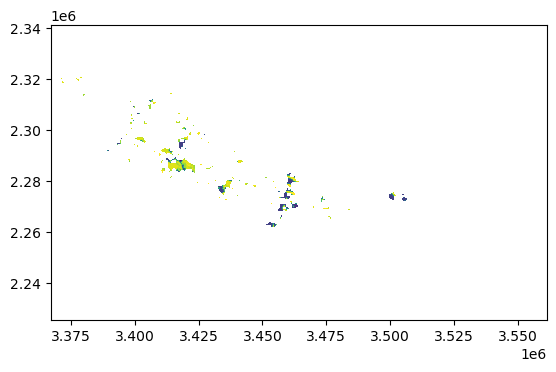

<AxesSubplot:>

In [30]:
fires_raster = rasterio.open(FIRE_YEAR)
show(fires_raster)

In [74]:
fires_raster.shape

## Check if the ratserization takes the first one or the last if there is overlaping 

(1156, 1943)

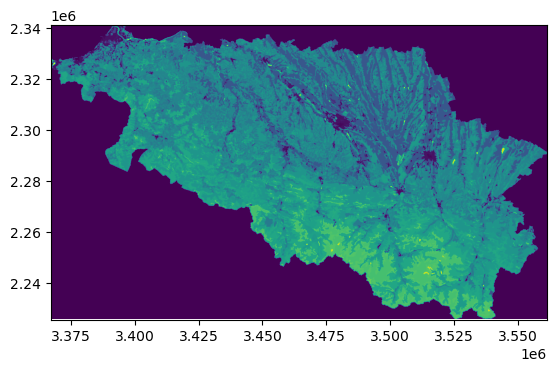

<AxesSubplot:>

In [65]:
lc_90 = rasterio.open(LC_CROPPED_90)
lc_00 = rasterio.open(LC_CROPPED_00)
lc_06 = rasterio.open(LC_CROPPED_06)
lc_12 = rasterio.open(LC_CROPPED_12)
lc_18 = rasterio.open(LC_CROPPED_18)

show(lc_00)

## Remove areas outside of the wanted region

In [140]:
len(lc_cr00[lc_cr00==0])

1022748

In [75]:
lc_00.shape

(1156, 1943)

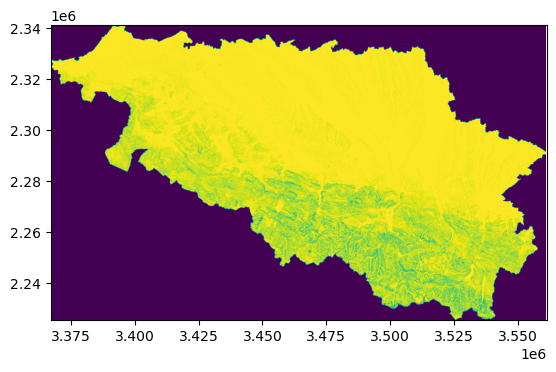

<AxesSubplot:>

In [45]:
slope = rasterio.open(SLOPES_CROPPED)
show(slope)

In [46]:
slope.shape

(1156, 1943)

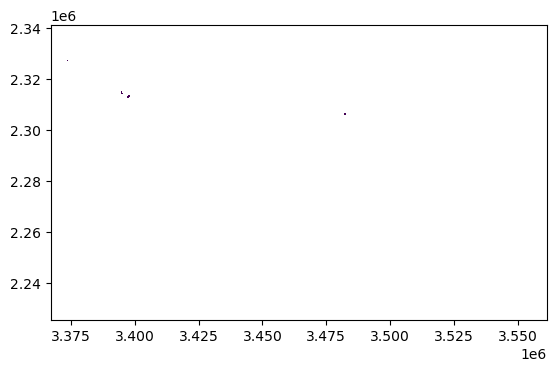

<AxesSubplot:>

In [48]:
protected = rasterio.open(PROTECTED)
show(protected)

In [49]:
protected.shape

(1156, 1943)

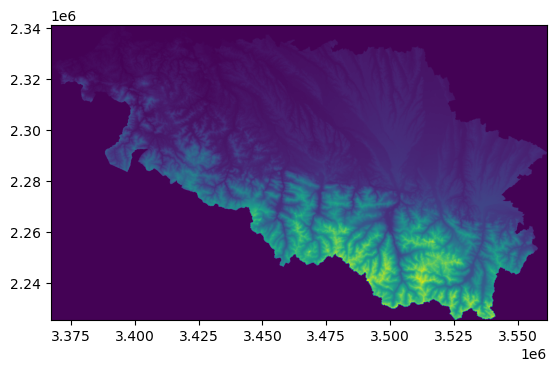

<AxesSubplot:>

In [51]:
dem = rasterio.open(DEM)
show(dem)

In [52]:
dem.shape

(1156, 1943)

In [139]:
len(dem_cr[dem_cr==0])

1026422

In [70]:
lc_cr90 = lc_90.read(1)
lc_cr90 = lc_cr90.flatten()

lc_cr00 = lc_00.read(1)
lc_cr00 = lc_cr00.flatten()

lc_cr06 = lc_06.read(1)
lc_cr06 = lc_cr06.flatten()

lc_cr12 = lc_12.read(1)
lc_cr12 = lc_cr12.flatten()

lc_cr18 = lc_18.read(1)
lc_cr18 = lc_cr18.flatten()

fires_cr = fires_raster.read(1)
fires_cr = fires_cr.flatten()

slopes_cr = slope.read(1)
slopes_cr = slopes_cr.flatten()

dem_cr = dem.read(1)
dem_cr = dem_cr.flatten()

protected_cr = protected.read(1)
protected_cr = protected_cr.flatten()

In [71]:
df_data = pd.DataFrame(data=np.c_[lc_cr90, lc_cr00, lc_cr06, lc_cr12, lc_cr18, slopes_cr, dem_cr, protected_cr, fires_cr])
df_data.columns = ['LC90', 'LC00', 'LC06', 'LC12', 'LC18', 'Slope', 'DEM', 'PROTECTED AREAS', 'Fire']
df_data

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,Fire
0,0.0,255.0,255.0,255.0,0.0,255.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2246106,0.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0
2246107,0.0,255.0,255.0,255.0,0.0,255.0,0.0,0.0,0.0


In [155]:
# Function to select the Land cover corresponding to the fire year
def find_year(fire_year, df):
    # Value of fire = 0 corresponds to no fire for the region
    if fire_year==0 : 
        return df['LC18']
    elif fire_year<2000 :
        return df['LC90']
    elif fire_year<2006 :
        return df['LC00']
    elif fire_year<2012 : 
        return df['LC06']
    elif fire_year<2018 :
        return df['LC12']
    else : return df['LC18']

In [156]:
# Selecting the Land cover corresponding to the fire year
df_data['LC'] = df_data.apply(lambda x : find_year(x['Fire'], x), axis=1)

In [157]:
df_data[(df_data['Fire'] != 0) & (df_data['Fire'] < 2006)]

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,Fire,LC,is_fire
388683,23.0,23.0,23.0,23.0,23.0,250.0,78.075195,0.0,2002.0,23.0,1
388684,23.0,23.0,23.0,23.0,23.0,249.0,73.623589,0.0,2002.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2158073,31.0,31.0,31.0,31.0,31.0,228.0,2886.672607,0.0,2005.0,31.0,1
2158074,31.0,31.0,31.0,31.0,31.0,239.0,2890.255859,0.0,2005.0,31.0,1


In [158]:
df_data['Year'] = df_data.apply(lambda x : 2018 if(x['Fire'] == 0) else x['Fire'], axis=1)

In [163]:
len(df_data[df_data['Year'] < 2016])

15646

In [162]:
len(df_data[df_data['Year'] >= 2018])

2229831

In [ ]:
df_data['is_fire'] = df_data.apply(lambda x : 1 if(x['Fire'] != 0) else 0 , axis=1)

In [154]:
df_data[(df_data['Fire'] != 0) & (df_data['Fire'] < 2006)]

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,Fire,LC,is_fire
388683,23.0,23.0,23.0,23.0,23.0,250.0,78.075195,0.0,2002.0,23.0,1
388684,23.0,23.0,23.0,23.0,23.0,249.0,73.623589,0.0,2002.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2158073,31.0,31.0,31.0,31.0,31.0,228.0,2886.672607,0.0,2005.0,31.0,1
2158074,31.0,31.0,31.0,31.0,31.0,239.0,2890.255859,0.0,2005.0,31.0,1


In [ ]:
df_data[df_data['is_fire'] == 0]

In [126]:
len(df_data[df_data['is_fire'] == 0])

2177702

In [128]:
len(df_data[df_data['is_fire'] == 1])

68406

In [72]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246108 entries, 0 to 2246107
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   LC90             float32
 1   LC00             float32
 2   LC06             float32
 3   LC12             float32
 4   LC18             float32
 5   Slope            float32
 6   DEM              float32
 7   PROTECTED AREAS  float32
 8   Fire             float32
dtypes: float32(9)
memory usage: 77.1 MB


In [115]:
len(df_data[df_data['Fire'] >= 2017])

52564

In [116]:
len(df_data[df_data['Fire'] < 2017])

2193544